54.1% sur Classique

50.7% sur Progressif 

## Dictionaires de données

In [1]:
%%time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

from glob import glob
import os

imPath = "Database/All_pictures/"
ls_path = glob(os.path.join(imPath, '*' ))

images_base_vide=[]
label_nom_vide=[]

for file in ls_path: 
    im = np.array(Image.open(file))[:,:,3]   #On charge l'image
    images_base_vide+=[im]
    label_nom_vide+=[file.split('\\')[1].split('_')[0]]   ## Attention ici Solène si ça marche pas . Pas meme code pour chemin ...

images_base_raw=np.array(images_base_vide)
label_nom_raw=np.array(label_nom_vide)

def print_exemple_image(num_image,X=images_base_raw,y=label_nom_vide) :
    plt.imshow(X[num_image],cmap='Greys')
    plt.suptitle("Image n°"+str(num_image)+" : "+str(y[num_image]), fontsize=20)
    
from sklearn.model_selection import train_test_split

ramdom_seed_fixée=5

def get_split_classique() :
    return train_test_split(images_base_raw, label_nom_raw, test_size=0.20, random_state=ramdom_seed_fixée)

X_train_classique , X_test_classique , Y_train_classique , Y_test_classique = get_split_classique()

label_to_OneHot = {'Deezer':[1,0,0,0],'Messenger':[0,1,0,0],'Facebook':[0,0,1,0],'Tinder':[0,0,0,1]}
label_to_num = {'Deezer':0 ,'Messenger':1 ,'Facebook':2,'Tinder':3} 

def transformation_dictionnaire_image(X,Y,data_aug=1,num_pixel_cote=64) : 
    taille = X.shape[0]
    data_base={'image':[], 'data': [], 'label_num' : [],'label_OneHot' : [],'nom_label' :[]}
    for i in range(taille) : 
        im = cv2.resize(X[i], (num_pixel_cote,num_pixel_cote))
        name=Y[i]
        
        for k in range(data_aug):
            num_rows, num_cols = im.shape[:2]
            rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), k*90, 1)
            im_rotation = cv2.warpAffine(im, rotation_matrix, (num_cols, num_rows))
        
            
            data_base['image']+=[im_rotation]
            data_base['data']+=[np.ndarray.flatten(im_rotation)]
            data_base['label_num']+=[label_to_num[name]]
            data_base['label_OneHot']+=[label_to_OneHot[name]]
            data_base['nom_label']+=[name]
            
            
    data_base['image']=np.array( data_base['image'])
    data_base['data']=np.array(data_base['data'])
    data_base['label_num']=np.array(data_base['label_num'])
    data_base['label_OneHot']=np.array(data_base['label_OneHot'])
    data_base['nom_label']=np.array(data_base['nom_label'])
    
    return data_base
        
Train_Classique = transformation_dictionnaire_image(X_train_classique,Y_train_classique)
Test_Classique = transformation_dictionnaire_image(X_test_classique,Y_test_classique)

catégories= ['Deezer','Facebook','Messenger','Tinder']

X_train_progressif , X_test_progressif , Y_train_progressif , Y_test_progressif = [],[],[],[]

for cat in catégories : 
    imPath = "Database/"+cat+"/"
    ls_path = glob(os.path.join(imPath, '*' ))

    taille_train=len(ls_path)-len(ls_path)//5
    #Train
    for file in ls_path[:taille_train]: 
        im = np.array(Image.open(file))[:,:,3]   #On charge l'image
        X_train_progressif+=[im]
        Y_train_progressif+=[file.split('\\')[1].split('_')[0]]

    #Test
    for file in ls_path[taille_train:]: 
        im = np.array(Image.open(file))[:,:,3]   #On charge l'image
        X_test_progressif+=[im]
        Y_test_progressif+=[file.split('\\')[1].split('_')[0]]
    

X_train_progressif=np.array(X_train_progressif)
Y_train_progressif=np.array(Y_train_progressif)
X_test_progressif=np.array(X_test_progressif)
Y_test_progressif=np.array(Y_test_progressif)


Train_Progressif = transformation_dictionnaire_image(X_train_progressif,Y_train_progressif)
Test_Progressif = transformation_dictionnaire_image(X_test_progressif,Y_test_progressif)

Wall time: 45 s


In [2]:
Train_Classique['image'].shape , Test_Classique['image'].shape

((1208, 64, 64), (303, 64, 64))

In [3]:
Train_Progressif['image'].shape , Test_Progressif['image'].shape

((1211, 64, 64), (300, 64, 64))

In [4]:
Train_Classique['data'][0]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import random

In [6]:
tf.__version__

'1.12.0'

In [7]:
Train_Classique['data'].shape[1]

4096

In [8]:
num_training=Train_Progressif['image'].shape[0]

# The images are stored in one-dimensional arrays of this length.
img_size_flat = Train_Progressif['data'].shape[1]

# Tuple with height and width of images used to reshape arrays.
img_shape = Train_Progressif['image'].shape[1:]

# Number of classes, one class for each of 10 digits.
num_classes = 4

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

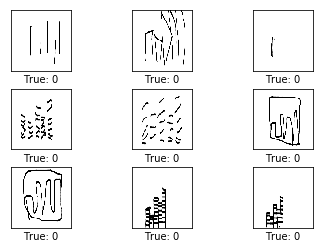

In [10]:
# Get the first images from the test-set.
images = Train_Progressif['image'][0:9]

# Get the true classes for those images.
cls_true = Train_Progressif['label_num'][0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [11]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [12]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [13]:
y_true_cls = tf.placeholder(tf.int64, [None])

In [14]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [15]:
biases = tf.Variable(tf.zeros([num_classes]))

In [16]:
logits = tf.matmul(x, weights) + biases

In [17]:
y_pred = tf.nn.softmax(logits)

In [18]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [19]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)

In [20]:
cost = tf.reduce_mean(cross_entropy)

In [21]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [22]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [23]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [24]:
session = tf.Session()

In [25]:
session.run(tf.global_variables_initializer())

In [26]:
batch_size = 100

In [27]:
def get_random_batch(X,y,batch_size) :
    index=random.sample(range(1,y.shape[0]), batch_size)
    return X[index], y[index]

In [28]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = get_random_batch(Train_Progressif['data'],Train_Progressif['label_OneHot'],batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

In [29]:
feed_dict_test = {x: Test_Progressif['data'],
                  y_true: Test_Progressif['label_OneHot'],
                  y_true_cls: Test_Progressif['label_num']}

In [30]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [49]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = Test_Progressif['label_num']

    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [32]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = Test_Progressif['data'][incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = Test_Progressif['label_num'][incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [33]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(2, 2)
    #fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [34]:
print_accuracy()

Accuracy on test-set: 24.3%


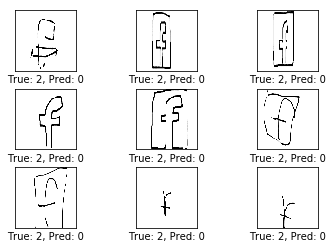

In [35]:
plot_example_errors()

In [36]:
optimize(num_iterations=1)

In [37]:
print_accuracy()

Accuracy on test-set: 36.0%


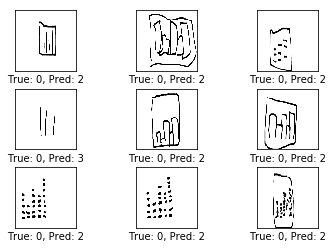

In [38]:
plot_example_errors()

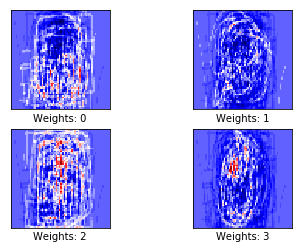

In [39]:
plot_weights()

In [40]:
optimize(num_iterations=9)

In [41]:
print_accuracy()

Accuracy on test-set: 52.0%


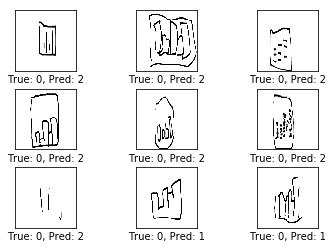

In [42]:
plot_example_errors()

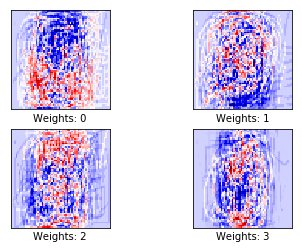

In [43]:
plot_weights()

In [44]:
optimize(num_iterations=990)

In [45]:
print_accuracy()

Accuracy on test-set: 50.7%


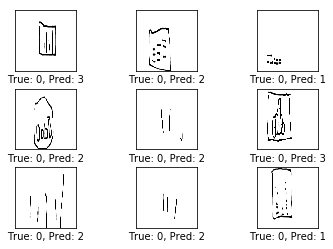

In [46]:
plot_example_errors()

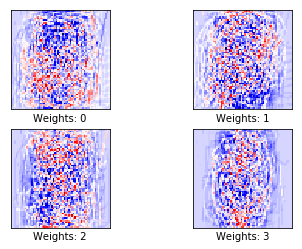

In [47]:
plot_weights()

[[46  9 14  4]
 [19 22 21 11]
 [12 11 45 15]
 [ 3 10 19 39]]


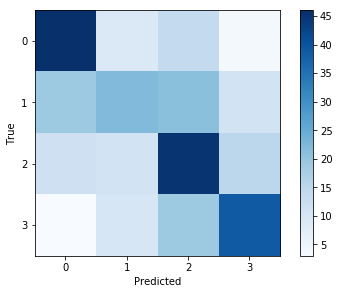

In [50]:
print_confusion_matrix()

In [51]:
optimize(num_iterations=1000)

print_accuracy()

Accuracy on test-set: 49.7%


In [52]:
optimize(num_iterations=1000)

print_accuracy()

Accuracy on test-set: 47.3%


In [53]:
optimize(num_iterations=10000)

print_accuracy()

Accuracy on test-set: 48.0%


In [54]:
%%time
optimize(num_iterations=10000)

print_accuracy()

Accuracy on test-set: 48.7%
Wall time: 1min 18s


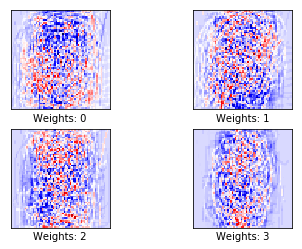

In [55]:
plot_weights()